# Heat Map Visualization

## Visualizing Heatmaps of Class Activation with Keras

## 1 - Loading VGG16 with pretrained weights

In [0]:
from keras.applications import VGG16
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

model = VGG16(weights='imagenet')

Using TensorFlow backend.


## 2 - Loading the test image of a Tiger

In [0]:
from google.colab import files
uploaded = files.upload()

Saving tiger.jpg to tiger.jpg


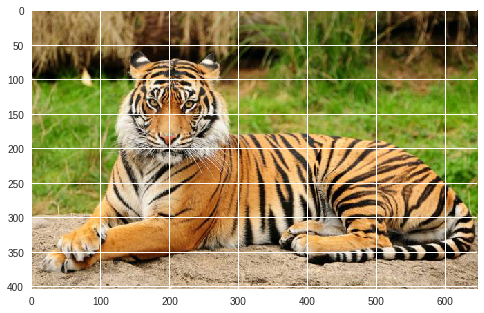

In [0]:
img_path = './tiger.jpg'

img1 = image.load_img(img_path)
plt.imshow(img1);

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

## 3 - VGG16 IMAGENET prediction

In [0]:
preds = model.predict(x)

print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 2us/step
Predicted: [('n02129604', 'tiger', 0.7590155), ('n02123159', 'tiger_cat', 0.24037585), ('n02128925', 'jaguar', 0.00016656627)]


In [0]:
np.argmax(preds[0])

292

## 4 - Output the feature map of the last conv layer 

In [0]:
tiger_output = model.output[:, 292]
last_conv_layer = model.get_layer('block5_conv3')

# Gradients of the Tiger class wrt to the block5_conv3 filer
grads = K.gradients(tiger_output, last_conv_layer.output)[0]

# Each entry is the mean intensity of the gradient over a specific feature-map channel 
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Accesses the values we just defined given our sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# Values of pooled_grads_value, conv_layer_output_value given our input image
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature-map array by the 'importance' 
# of this channel regarding the input image 
for i in range(512):
    #channel-wise mean of the resulting feature map is the Heatmap of the CAM
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

## 5 - Plotting the heat map

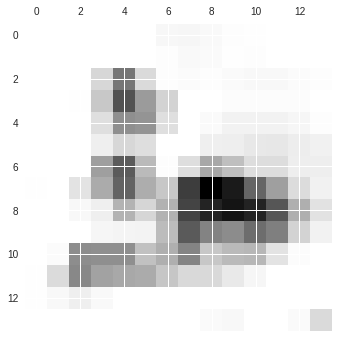

In [0]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

## 6 - Using OpenCV to overlay the heat map over the input image (tiger.jpg)

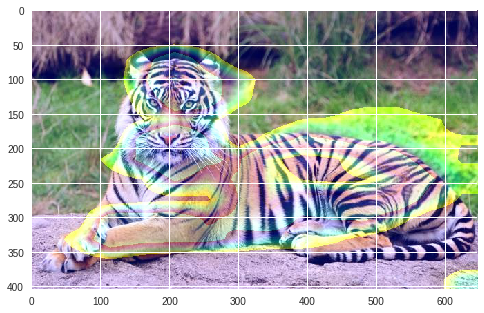

In [0]:
import cv2

# Read the input image
img = cv2.imread(img_path)

# Transform the heat map to opencv
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

# Apply the color map over the heat map
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# New image with the heat map
superimposed_img = heatmap * 0.4 + img

save_img_path = './tiger_heat_map.jpg'

# Save image
cv2.imwrite(save_img_path, superimposed_img)

# Load and Plot image
img1 = image.load_img(save_img_path)
plt.imshow(img1);